In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [3]:
df = pd.read_csv("../data/raw/diabetes.csv")
df.shape, df.head()


((768, 9),
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0            6      148             72             35        0  33.6   
 1            1       85             66             29        0  26.6   
 2            8      183             64              0        0  23.3   
 3            1       89             66             23       94  28.1   
 4            0      137             40             35      168  43.1   
 
    DiabetesPedigreeFunction  Age  Outcome  
 0                     0.627   50        1  
 1                     0.351   31        0  
 2                     0.672   32        1  
 3                     0.167   21        0  
 4                     2.288   33        1  )

In [4]:
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# kaç tane 0 vardı?
#PIMA’da aşağıdaki sütunlarda 0 fizyolojik olarak mantıksız kabul edilir:
#Glucose, BloodPressure, SkinThickness, Insulin, BMI
zero_counts_before = df[cols_with_zero].eq(0).sum()
zero_counts_before


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [5]:
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

# artık NaN sayıları:
nan_counts = df[cols_with_zero].isnull().sum()
nan_counts


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [6]:
(df.isnull().mean() * 100).sort_values(ascending=False)
#missing oranı (%)
#Explicit missing yoktu ama 0 değerler missing gibi ele alındı.”

Insulin                     48.697917
SkinThickness               29.557292
BloodPressure                4.557292
BMI                          1.432292
Glucose                      0.651042
Pregnancies                  0.000000
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64

In [7]:
imputer = SimpleImputer(strategy="median")
#Imputation (median) + kontrol
#Median: outlier’a daha dayanıklı olduğu için iyi default.
df[cols_with_zero] = imputer.fit_transform(df[cols_with_zero])

# kontrol: NaN kaldı mı?
df[cols_with_zero].isnull().sum()


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

In [8]:
features = df.drop(columns=["Outcome"]) #IQR ile outlier sayıları

Q1 = features.quantile(0.25)
Q3 = features.quantile(0.75)
IQR = Q3 - Q1

iqr_outlier_mask = (features < (Q1 - 1.5 * IQR)) | (features > (Q3 + 1.5 * IQR))
iqr_outlier_counts = iqr_outlier_mask.sum().sort_values(ascending=False)

iqr_outlier_counts


Insulin                     346
SkinThickness                87
DiabetesPedigreeFunction     29
BloodPressure                14
Age                           9
BMI                           8
Pregnancies                   4
Glucose                       0
dtype: int64

In [9]:
from scipy import stats   #Z-score (|z| > 3)

z = np.abs(stats.zscore(features))
z_outlier_counts = pd.Series((z > 3).sum(axis=0), index=features.columns).sort_values(ascending=False)

z_outlier_counts


Insulin                     20
DiabetesPedigreeFunction    11
BloodPressure                8
BMI                          5
Age                          5
Pregnancies                  4
SkinThickness                4
Glucose                      0
dtype: int64

In [10]:
#IQR sınırları ile cap uygulaması (Outcome hariç)
df_capped = df.copy()
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

for col in features.columns:
    df_capped[col] = df_capped[col].clip(lower[col], upper[col])

df_capped.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,125.000,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,125.000,26.6,0.351,31.0,0
2,8.0,183.0,64.0,29.0,125.000,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,112.875,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,135.875,43.1,1.200,33.0,1


C:\Users\alpce\intro-to-data-science-diabetes\.venv\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


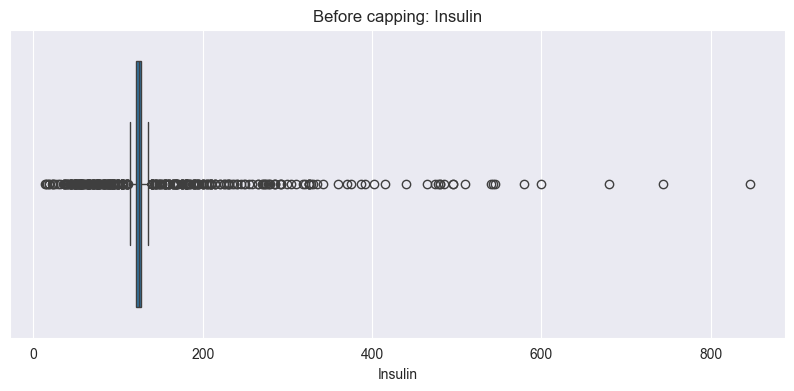

C:\Users\alpce\intro-to-data-science-diabetes\.venv\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


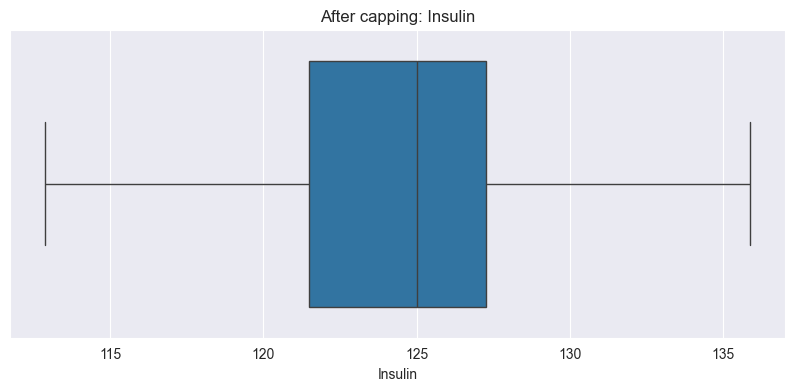

In [11]:
#Cap öncesi/sonrası kısa kontrol (grafik)
col_to_check = "Insulin"  # istersen Glucose/BMI da bak
plt.figure(figsize=(10,4))
sns.boxplot(x=df[col_to_check])
plt.title(f"Before capping: {col_to_check}")
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x=df_capped[col_to_check])
plt.title(f"After capping: {col_to_check}")
plt.show()


In [12]:
#Feature/Target ayır + Train/Test split (stratify)
X = df_capped.drop(columns=["Outcome"])
y = df_capped["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((614, 8),
 (154, 8),
 np.float64(0.3485342019543974),
 np.float64(0.35064935064935066))

In [13]:
#Scaling (StandardScaler) — SVM/LR için şart
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((614, 8), (154, 8))

In [14]:
#Processed dataset” kaydet
processed_path = "../data/processed/diabetes_preprocessed.csv"
df_capped.to_csv(processed_path, index=False)
processed_path


'../data/processed/diabetes_preprocessed.csv'